# Template for HW4
Use this file as a template. In your submission, save any computation results and outputs and submit the file, so we can see it when we grade.

You'll be using the tutorial at https://medium.com/data-science-in-your-pocket/modernbert-for-text-classification-04d7fba42dae as a starting point.
Then you'll modify it so that it uses the dataset "sentence-transformers/all-nli" instead. You'll need to really understand how the code works to do this: look up the documentation for the individual functions. Read about the dataset and find out its structure.

In [1]:
!pip install datasets
!pip install transformers
!pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [2]:

#load modernbert (base) and your dataset here. Follow the tutorial (with any necessary modifications) at: https://medium.com/data-science-in-your-pocket/modernbert-for-text-classification-04d7fba42dae
from datasets import load_dataset
from datasets.arrow_dataset import Dataset
from datasets.dataset_dict import DatasetDict, IterableDatasetDict
from datasets.iterable_dataset import IterableDataset
import numpy as np

# Dataset id from huggingface.co/dataset
# dataset_id = "argilla/synthetic-domain-text-classification"
dataset_id = "sentence-transformers/all-nli"

# Load raw dataset
# train_dataset = load_dataset(dataset_id, split='train')
train_dataset = load_dataset(dataset_id, 'pair-class', split='train[:3%]')
#divide train set into fraction of the size, so more computationally feasible


split_dataset = train_dataset.train_test_split(test_size=0.1)
# print(split_dataset['train'][5:7])
print(split_dataset)

# create a new column in split_dataset which concatenates the "premise" and "hypothesis" columns
split_dataset = split_dataset.map(lambda x: {"text": x["premise"] + " <s> " + x["hypothesis"]}, remove_columns=["premise", "hypothesis"])
# print(split_dataset['train'][5:7])
# print(split_dataset)

from transformers import AutoTokenizer

# Model id to load the tokenizer
model_id = "answerdotai/ModernBERT-base"

# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Tokenize helper function
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding="max_length", return_tensors="pt", max_length=500)#tokenizer.model_max_length)


# Tokenize dataset
if "label" in split_dataset["train"].features.keys():
    split_dataset =  split_dataset.rename_column("label", "labels") # to match Trainer
tokenized_dataset = split_dataset.map(tokenize, batched=True, remove_columns=["text"])

from transformers import AutoModelForSequenceClassification

# Model id to load the tokenizer
model_id = "answerdotai/ModernBERT-base"

# Prepare model labels - useful for inference
labels = tokenized_dataset["train"].features["labels"].names
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

# Download the model from huggingface.co/models
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=num_labels, label2id=label2id, id2label=id2label,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/69.5M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


dev-00000-of-00001.parquet:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


test-00000-of-00001.parquet:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/942069 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/19657 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/19656 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 25435
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 2827
    })
})


Map:   0%|          | 0/25435 [00:00<?, ? examples/s]

Map:   0%|          | 0/2827 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Map:   0%|          | 0/25435 [00:00<?, ? examples/s]

Map:   0%|          | 0/2827 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# train your model here, using fine-tuning. Print out training data and save it as part of this notebook file. Again follow the tutorial (with any necessary modifications) at: https://medium.com/data-science-in-your-pocket/modernbert-for-text-classification-04d7fba42dae

from transformers import Trainer, TrainingArguments

# Define training args
training_args = TrainingArguments(
    output_dir= "ModernBERT-domain-classifier",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=2,
    learning_rate=5e-5,
    num_train_epochs=2,
    bf16=True, # bfloat16 training
    optim="adamw_torch_fused", # improved optimizer
    # logging & evaluation strategies
    logging_strategy="steps",
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_total_limit=2,
    load_best_model_at_end=True,
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"] #note that we're using the test set as the validation set here---normally a no-no!
)
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jnmaharaj (jnmaharaj-university-of-south-florida) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


W0424 15:59:31.339000 1761 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode


Step,Training Loss,Validation Loss
500,0.976900,0.678978
1000,0.810500,0.735543
1500,0.690500,0.646020
2000,0.717800,0.703083
2500,0.673300,0.644654
3000,0.628300,0.514566
3500,0.621000,0.579518
4000,0.614300,0.646837
4500,0.594000,0.575505
5000,0.581700,0.535126


Step,Training Loss,Validation Loss
500,0.976900,0.678978
1000,0.810500,0.735543
1500,0.690500,0.646020
2000,0.717800,0.703083
2500,0.673300,0.644654
3000,0.628300,0.514566
3500,0.621000,0.579518
4000,0.614300,0.646837
4500,0.594000,0.575505
5000,0.581700,0.535126


TrainOutput(global_step=12718, training_loss=0.5081036089726038, metrics={'train_runtime': 2867.9213, 'train_samples_per_second': 17.738, 'train_steps_per_second': 4.435, 'total_flos': 1.692819511767e+16, 'train_loss': 0.5081036089726038, 'epoch': 2.0})

In [4]:
# Save model and tokenizer
model.save_pretrained("ModernBERT-domain-classifier")
tokenizer.save_pretrained("ModernBERT-domain-classifier")

# Zip the folder
!zip -r ModernBERT-domain-classifier.zip ModernBERT-domain-classifier

# Download the zip
from google.colab import files
files.download("ModernBERT-domain-classifier.zip")


  adding: ModernBERT-domain-classifier/ (stored 0%)
  adding: ModernBERT-domain-classifier/tokenizer_config.json (deflated 95%)
  adding: ModernBERT-domain-classifier/tokenizer.json (deflated 82%)
  adding: ModernBERT-domain-classifier/checkpoint-3000/ (stored 0%)
  adding: ModernBERT-domain-classifier/checkpoint-3000/rng_state.pth (deflated 25%)
  adding: ModernBERT-domain-classifier/checkpoint-3000/training_args.bin (deflated 52%)
  adding: ModernBERT-domain-classifier/checkpoint-3000/optimizer.pt (deflated 29%)
  adding: ModernBERT-domain-classifier/checkpoint-3000/model.safetensors (deflated 7%)
  adding: ModernBERT-domain-classifier/checkpoint-3000/trainer_state.json (deflated 71%)
  adding: ModernBERT-domain-classifier/checkpoint-3000/config.json (deflated 59%)
  adding: ModernBERT-domain-classifier/checkpoint-3000/scheduler.pt (deflated 55%)
  adding: ModernBERT-domain-classifier/runs/ (stored 0%)
  adding: ModernBERT-domain-classifier/runs/Apr24_15-58-23_af8a47a993e3/ (stored 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
import numpy as np

# test your trained model on the test set here. Report statistics and save the test data as part of this notebook file.
predictions = trainer.predict(tokenized_dataset["test"])

# Process the prediction results (predictions, label_ids, metrics)
predicted_labels = np.argmax(predictions.predictions, axis=1)
predicted_label = id2label[str(predicted_labels[0])]


example_data = [split_dataset['train'][0]]
print("Example Input:", example_data[0]['text'])
print(f"Predicted Label: {predicted_label}")
print(f"Actual Label: {id2label[str(example_data[0]['labels'])]}")



Example Input: A man resting on a street. <s> A man resting on a street.
Predicted Label: entailment
Actual Label: entailment


### Question 1
Analyze the true positive / false positive / true negative / false negative rates overall, treating every answer as either wrong or right (e.g., if the correct answer was 0, then only 0 is correct and 1 or 2 are both wrong). What results do you get? What does this tell you?

-------

Based solely on the accuracy of solely right or solely wrong predictions of the hypothesis given the premise, the model has a accuracy rate of roughly 82%. Due to this model having 3 types of classification labels (entailment, nuetral and contradiction), we cannot do regular binary classification. However, we can still deduce from the accuracy alone that the model is able to handle different cases in premise predictions to a reasonable extent.

While accuracy is still a good measure of the model's performance, it treats all incorrect predictions the same and does not reveal more specific details telling us why some classes are more challenging for the model to predict accurately.

Overall, the model demonstrates a solid understanding of the task, especially given the limited training duration. However, a deeper analysis such as  precision for each class, recall, and evaluating the confusion matrix will provide more insight into the specific types of errors the model is making and guide more targeted improvements for the model's performance.

Overall Accuracy: 82.21%


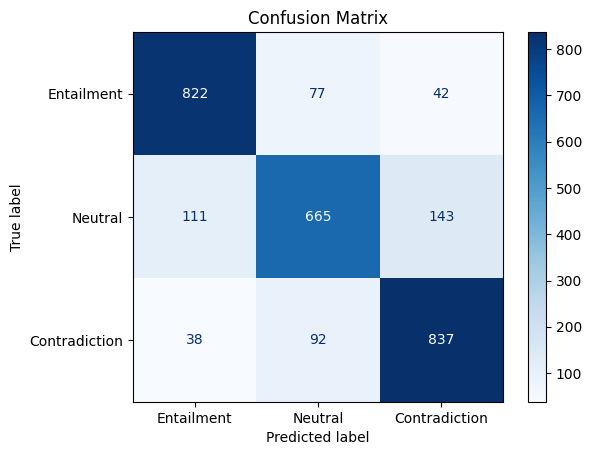

In [58]:
# any code used to answer Question 2 goes here

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# given that labelid2 = {'0': 'entailment', '1': 'neutral', '2': 'contradiction'}
true_labels = predictions.label_ids
classes = np.unique(true_labels)  # get unique classes of labels in dataset
results = {}  # store TP, FP, TN, FN for each class

predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

for c in classes:  # iterate over labels and get sum of TP, FP, TN, FN
    TP = np.sum((predicted_labels == c) & (true_labels == c))
    FP = np.sum((predicted_labels == c) & (true_labels != c))
    TN = np.sum((predicted_labels != c) & (true_labels != c))
    FN = np.sum((predicted_labels != c) & (true_labels == c))
    results[c] = {"TP": TP, "FP": FP, "TN": TN, "FN": FN}

TP_TN = np.sum(predicted_labels == true_labels)   # solely right predictions
FP_FN = np.sum(predicted_labels != true_labels)  # solely wrong predictions
acc = TP_TN / (TP_TN + FP_FN) * 100  # accuracy for treating every answer as either wrong or right
print(f"Overall Accuracy: {acc:.2f}%")

# Create and plot the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("question1_cmatrix.png")
plt.show()




### Question 2
Now analyze the TP/FP/TN/FN rates *for each category* (contradiction, entailment, neutral). What do you learn? What does this tell you that you couldn't tell from the answer to Question 1?

-------

These parameters were used to further evaluate the model's performance:
* Precision per class: proportion of predicted positive results that are actually correct for this class.
* Recall: proportion of actual positive cases that were correctly identified for this class.
* F1: mean of precision and recall, balancing the two. It reflects both false positives and false negatives in 1 score.
* Accuracy: proportion of all predictions(across all classes) that were correct.
* Macro-average: average of the metric (precision, recall, or F1) for each class, treating all classes equally.
* Weighted Average: average for each class, weighted by the number of true instances in each class. Treats classes as imbalanced

Based on the above parameters, the model's classification report showed the following performance:

- Entailment: Precision = 0.85, Recall = 0.87, F1 = 0.86
- Neutral: Precision = 0.80, Recall = 0.72, F1 = 0.76
- Contradiction: Precision = 0.82, Recall = 0.87, F1 = 0.84

From these findings, we can deduce that both the entailment and contradiction classes outperformed the neutral class. This indicates that the model was more confident and consistent in identifying clear logical relationships where the premise either supported(entailment) or went against(contradiction) the hypothesis.

Moreover, the neutral case had the worst performance with a notably lower recall(0.72). This suggests that the model had issues picking up when the premise was unrelated or ambiguously related in an impartial/subtle to the hypothesis. This may be the most difficult for the model to pick up because there isn't a direct correlation or contradiction in the two sentences that is easier to identify like in the other two cases. Understanding neutral phrases may require a more detailed understanding of the context of the given premise or general world knowledge which may not have been fully captured during training.

This analysis gives us a better understanding of how well each class could be predicted which could not be determined in the first question.




In [59]:
from sklearn.metrics import classification_report

labels = ['Entailment', 'Neutral', 'Contradiction']

# print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=labels))
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)
# F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
# Accuracy = (TP + TN) / (TP + TN + FP + FN)


Classification Report:
               precision    recall  f1-score   support

   Entailment       0.85      0.87      0.86       941
      Neutral       0.80      0.72      0.76       919
Contradiction       0.82      0.87      0.84       967

     accuracy                           0.82      2827
    macro avg       0.82      0.82      0.82      2827
 weighted avg       0.82      0.82      0.82      2827



### Question 3
Analyze specific errors. For example, look at questions that had (x) as a correct answer but the model guessed (y) instead. Look at specific cases. What do you notice? Come up with at least 4 hypotheses about what kinds of problems it's getting right and wrong.

-------

The three most frequent prediction inaccuracies involved the neutral class, with the model either mistaking neutral labels for entailment or contradiction or vice-versa. This suggests that the model struggled most with recognizing statements that are unrelated or weakly related, implying that the model has trouble distinguishing whether two sentences are truly logically unrelated versus being implicitly related (entailment) or logically contradicting.

After looking at a few examples for each specific prediction case, I found that the model tends to struggle with distinguishing subtle semantic relationships, especially when the relationship between premise and hypothesis is ambiguous or indirect. Four hypotheses I came up with as to why the model has these problems are:
1. Many misclassifications (mostly between nuetral and entailment) happen when sentences share synonyms but differ subtly in meaning or context of the given premise/hypothesis.
2. Short premises provide fewer context clues, which encourages the model to 'guess' based on weak signals like word overlap rather than the actual meaning of the sentence.
3. The model misinterprets double negatives or subtle negations and treats the premise without using the intended meaning.
4. There is an overconfident prediction in entailment when word overlap is high, even if the logic is weak.

In [60]:
# any code used to answer Question 3 goes here

from collections import Counter
import random
# map label IDs to their names for better readability
label_names = {0: 'Entailment', 1: 'Neutral', 2: 'Contradiction'}

# pair true labels with predicted labels
pair_counts = Counter(zip(true_labels, predicted_labels))

print("Most frequent pairs (True -> Predicted):\n")
# print top 9 most common error patterns
top_pairs = pair_counts.most_common(9)
for pair, count in top_pairs:
    print(f"True Label: {label_names[pair[0]]} ({pair[0]}) -> Predicted: {label_names[pair[1]]} ({pair[1]}) | Count: {count}")
    print("")


Most frequent pairs (True -> Predicted):

True Label: Contradiction (2) -> Predicted: Contradiction (2) | Count: 837

True Label: Entailment (0) -> Predicted: Entailment (0) | Count: 822

True Label: Neutral (1) -> Predicted: Neutral (1) | Count: 665

True Label: Neutral (1) -> Predicted: Contradiction (2) | Count: 143

True Label: Neutral (1) -> Predicted: Entailment (0) | Count: 111

True Label: Contradiction (2) -> Predicted: Neutral (1) | Count: 92

True Label: Entailment (0) -> Predicted: Neutral (1) | Count: 77

True Label: Entailment (0) -> Predicted: Contradiction (2) | Count: 42

True Label: Contradiction (2) -> Predicted: Entailment (0) | Count: 38



### Question 4

Given your hypotheses from question 3, create a few test cases manually and see if they confirm or refute your hypotheses.

-------

**answer this question here. Add additional code blocks to show your work and/or display figures/charts.**

I used two examples to test my hypotheses from the third question. Based on the predicted results, all my hypotheses have been proved correct as for each of them, the trained model did not accurately predict at least one case example. We can deduct that it is difficult under certain circumstances for the model to truly differentiate nuetral sentences from both entailmemt and contradiction.

For the cases in hypothesis 2 and 3, there was a suprising finding. The shorter sentences made the model predict contradiction  when the label was entailment. I assumend it would lead to a nuetral prediction but this suggests the model might interpret the lack of clear alignment as conflict rather than inferred agreement. Also it appears that multiple negations in the premise obscures the true meaning of the sentence, thus when the model comes across this type of formatting, it predicts contradiction instead of logically following the premise's true definition.

Both hypothesis 1 and 4 performed as expected. They exposed the shortcomings of model in identifying differentiating the nuetral case properly. The model struggles when synonyms or the exact same words are used in both the premise and hypothesis, leading to predicting 'entailment' most frequently even if the label is nuetral or contradiction.

Overall, these test examples confirm that while the model performs reasonably well overall, it still exhibits notable weaknesses in nuanced language scenarios. Instances involving predicting the neutral case, short or ambiguous inputs, and semantic subtleties can be improved upoon by further fine-tuning and adding more contextual sensitivity to assist the model in reducing these inconsistencies.

In [61]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# load trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("ModernBERT-domain-classifier")
model = AutoModelForSequenceClassification.from_pretrained("ModernBERT-domain-classifier")

# define test cases with expected labels
# Label mapping: 0 = Entailment, 1 = Neutral, 2 = Contradiction
# two examples for each hypotheses
test_examples = [
    # hypothesis 1 - share similar words but subtle differnces in context
    {"premise": "A group of adults is sitting at a table", "hypothesis": "Grown ups are having a meeting", "expected": 1},               # Neutral case
    {"premise": "Two friends are walking in the park", "hypothesis": "A couple of people are outside together", "expected": 1},               # Neutral case

    # hypothesis 2 - short premise/label can lead to guessing
    {"premise": "Bob loves tilapia", "hypothesis": "He eats fish", "expected": 0},                                                   # Contradiction case
    {"premise": "Mary has a car", "hypothesis": "Mary drove here", "expected": 0},                                                     # Entailment case

    # hypothesis 3 - cannot understand double negatives or inconvenient negatives
    {"premise": "The man did not finish the race", "hypothesis": "The man completed the race", "expected": 2},                        # Contradiction case
    {"premise": "She never eats meat but sometimes eats seafood", "hypothesis": "She is not vegan but a pescatarian", "expected": 0}, # Entailment case

    # hypothesis 4 - when word overlap is high then the model may predict entailment
    {"premise": "A dog is sleeping next to a brown ball", "hypothesis": "A brown dog is playing with a ball", "expected": 2},            # contradiction case
    {"premise": "The guy is holding a bat and drinking from his cup", "hypothesis": "The bat is drinking from a cup", "expected": 1}     # neutral case
]

# tokenize the new examples
encoded_inputs = tokenizer(
    [ex["premise"] for ex in test_examples],
    [ex["hypothesis"] for ex in test_examples],
    padding=True,
    truncation=True,
    return_tensors="pt"
)

# move tensors to model device
encoded_inputs = {key: val.to(model.device) for key, val in encoded_inputs.items()}

# run inferences
with torch.no_grad():
    outputs = model(**encoded_inputs)
    logits = outputs.logits
    predicted_labels = np.argmax(logits.cpu().numpy(), axis=1)

# output predictions
for i, example in enumerate(test_examples):
    predicted_label = id2label[str(predicted_labels[i])]
    actual_label = id2label[str(example["expected"])]
    print("Example Input:", f"Premise: {example['premise']} | Hypothesis: {example['hypothesis']}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Actual Label: {actual_label}\n")



Example Input: Premise: A group of adults is sitting at a table | Hypothesis: Grown ups are having a meeting
Predicted Label: contradiction
Actual Label: neutral

Example Input: Premise: Two friends are walking in the park | Hypothesis: A couple of people are outside together
Predicted Label: entailment
Actual Label: neutral

Example Input: Premise: Bob loves tilapia | Hypothesis: He eats fish
Predicted Label: contradiction
Actual Label: entailment

Example Input: Premise: Mary has a car | Hypothesis: Mary drove here
Predicted Label: contradiction
Actual Label: entailment

Example Input: Premise: The man did not finish the race | Hypothesis: The man completed the race
Predicted Label: entailment
Actual Label: contradiction

Example Input: Premise: She never eats meat but sometimes eats seafood | Hypothesis: She is not vegan but a pescatarian
Predicted Label: contradiction
Actual Label: entailment

Example Input: Premise: A dog is sleeping next to a brown ball | Hypothesis: A brown dog 